<a href="https://colab.research.google.com/github/AllerLydia/Deep-Learning/blob/master/PyTorch_quick_start.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor


In [40]:
training_data = datasets.FashionMNIST(
    root = "data",
    transform = ToTensor(),
    train = True,
    download=True
)

In [41]:
test_data = datasets.FashionMNIST(
    root = "data",
    transform = ToTensor(),
    train = False,
    download = True
)

In [42]:
BATCH_SIZE = 64

train_dataloader = DataLoader(training_data, batch_size = BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size = BATCH_SIZE, shuffle=False)

##### Define data from customerized source

In [43]:
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset

In [44]:
class CustomImageDataset(Dataset):
  def __init__(self, annotations_file, img_dir, transform = None, target_transform=None):
    self.img_labels = pd.read_csv(annotations_file),
    self.img_dir = img_dir,
    self.transform = transform,
    self.target_transform = target_transform

  def __len__(self):
    return len(self.img_label)

  def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx,0])
    image = read_image(img_path)
    label = self.img_labels.iloc[idx,1]
    if self.transform:
      image = self.transform(image)
    if self.target_transform:
      label = self.target_transform(label)

    return image, label


#####  Visulize dataset 

In [45]:
import matplotlib.pyplot as plt

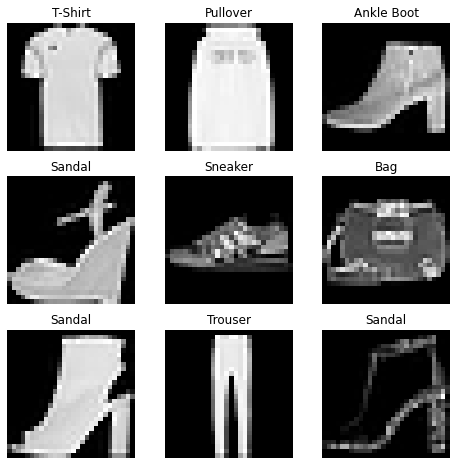

In [46]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize = (8, 8))

cols, rows = 3, 3
for i in range(1, cols * rows + 1):
  sample_idx = torch.randint(len(training_data), size=(1, )).item()
  img, label = training_data[sample_idx]
  figure.add_subplot(rows, cols, i)
  plt.title(labels_map[label])
  plt.axis("off")
  plt.imshow(img.squeeze(), cmap = "gray")
plt.show()

In [47]:
for X, y in test_dataloader:
  print(f"Shape of X [N, C, H, W]: {X.shape}")
  print(f"Shape of y: {y.shape} {y.dtype}")
  break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


##### creating model

In [48]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

In [49]:
device

'cpu'

In [57]:
class NeuralNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
        nn.Linear(28*28, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.ReLU(),
        nn.Linear(512, 10)
    )

  def forward(self, x):
    x = self.flatten(x)
    logits = self.linear_relu_stack(x)
    return logits

model = NeuralNetwork().to(device)
model

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [58]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model.parameters(),
                            lr = 0.1)

In [59]:
def train(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  model.train()
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    pred = model(X)
    loss = loss_fn(pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 100 == 0:
      loss, current = loss.item(), (batch + 1) * len(X)
      print(f"loss: {loss:>7f} | [{current:>5d} / {size: >5d}]")

In [62]:
def test(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  model.eval()
  test_loss, correct = 0, 0
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [63]:
epochs = 5
for t in range(epochs):
  print(f"Epoch {t+1} \n-------------------------")
  train(train_dataloader, model, loss_fn, optimizer)
  test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1 
-------------------------
loss: 0.306214 | [   64 / 60000]
loss: 0.414678 | [ 6464 / 60000]
loss: 0.498794 | [12864 / 60000]
loss: 0.400171 | [19264 / 60000]
loss: 0.180940 | [25664 / 60000]
loss: 0.539912 | [32064 / 60000]
loss: 0.383752 | [38464 / 60000]
loss: 0.362338 | [44864 / 60000]
loss: 0.407663 | [51264 / 60000]
loss: 0.456717 | [57664 / 60000]
Test Error: 
 Accuracy: 83.3%, Avg loss: 0.451742 

Epoch 2 
-------------------------
loss: 0.493942 | [   64 / 60000]
loss: 0.301702 | [ 6464 / 60000]
loss: 0.297263 | [12864 / 60000]
loss: 0.315203 | [19264 / 60000]
loss: 0.313504 | [25664 / 60000]
loss: 0.487163 | [32064 / 60000]
loss: 0.324142 | [38464 / 60000]
loss: 0.358851 | [44864 / 60000]
loss: 0.415054 | [51264 / 60000]
loss: 0.285014 | [57664 / 60000]
Test Error: 
 Accuracy: 80.1%, Avg loss: 0.553438 

Epoch 3 
-------------------------
loss: 0.361333 | [   64 / 60000]
loss: 0.422107 | [ 6464 / 60000]
loss: 0.406391 | [12864 / 60000]
loss: 0.335848 | [19264 / 60000]

##### Saving Models

In [64]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


##### Loading models

In [65]:
model_loaded = NeuralNetwork()
model_loaded.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

In [68]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model_loaded.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
  pred = model_loaded(x)
  predicted, actual = classes[pred[0].argmax(0)], classes[y]
  print(f'Predicted: "{predicted}", Actual: "{actual}"')


Predicted: "Ankle boot", Actual: "Ankle boot"


In [80]:
test_data[0][0].shape

torch.Size([1, 28, 28])

In [87]:
model_loaded(x)[0].argmax(0)

tensor(9)

In [88]:
import numpy as np    
A = np.matrix([[1,2,3,33],[4,5,6,66],[7,8,9,99]])


In [95]:
A[1:,2]

matrix([[6],
        [9]])